In [1]:
import pickle
with open('../gbs_ase.pickle', 'rb') as handle:
    my_ase = pickle.load(handle)

The centrosymmetry parameter measures how different the atom is to perfect fcc by measuring the distances of the neighboring atoms. 
In the next cell we look at a scatter plot of each of our ten sample gbs. We are plotting the atom by its csym value. As expected, there are many atoms near 0.

If you wish to use CNA instead of centrosymmetry replace the key c_csym with c_cna

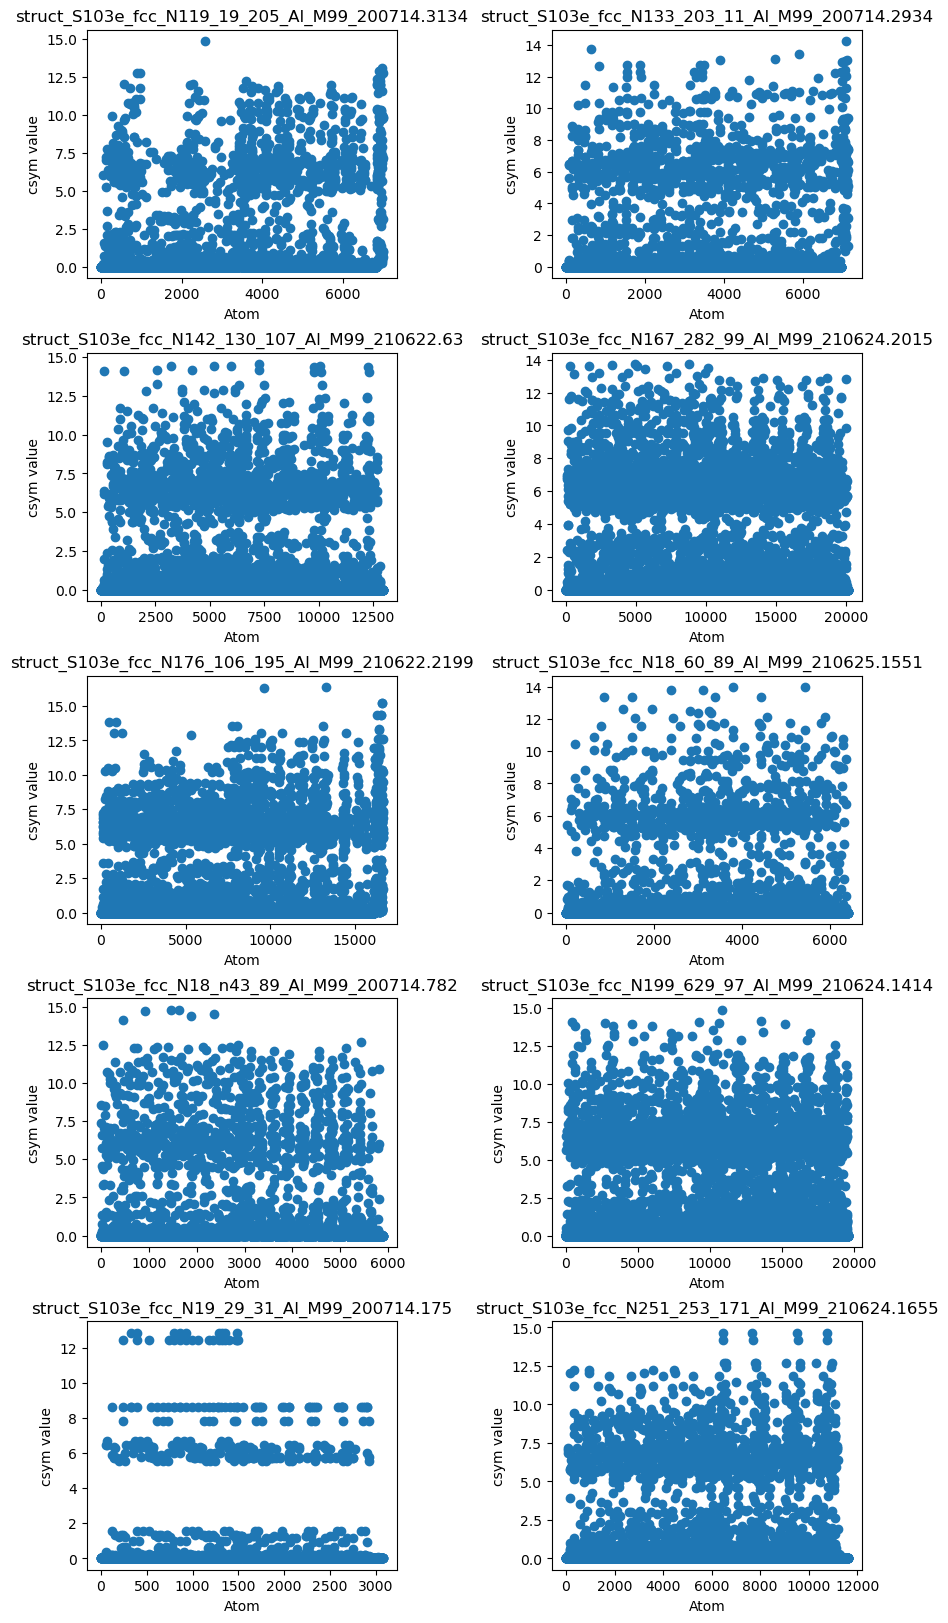

In [9]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10, 20))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.scatter(range(len(my_ase[i].arrays['c_csym'])),my_ase[i].arrays['c_csym'])
    ax.set_title(my_ase[i].compute_id)
    ax.set_xlabel("Atom")
    ax.set_ylabel("csym value")
    
plt.subplots_adjust(wspace=0.5, hspace=0.3)



For no reason specifically other than my belief that the atoms with a zero centrosymmetry value are not that important we can remove them. We can also plot them as a histogram.

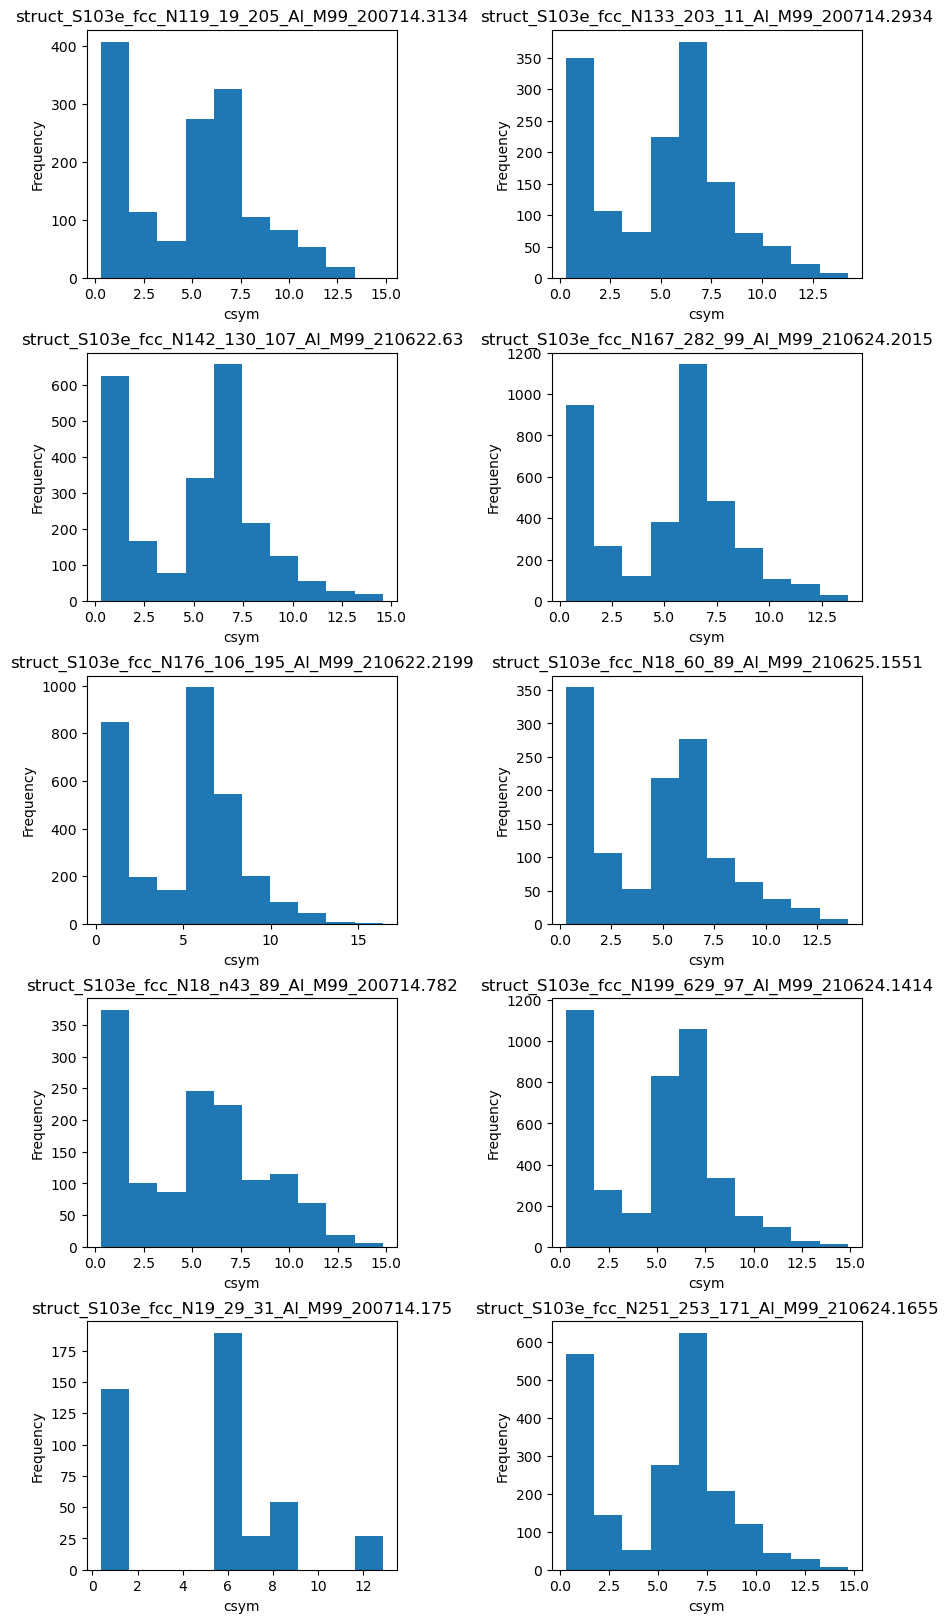

In [10]:
import numpy as np
def get_csym(gb):
    return gb.arrays['c_csym'].flatten()

def filter_csym_index(gb,min_val):
    idx = np.argwhere(get_csym(gb)>min_val)
    idx = idx.reshape(np.shape(idx)[0])
    return idx

fig, axs = plt.subplots(5, 2, figsize=(10, 20))
axs = axs.flatten()

for i, ax in enumerate(axs):
    my_idx = filter_csym_index(my_ase[i],.3)
    ax.hist(my_ase[i].arrays['c_csym'][my_idx])
    ax.set_title(my_ase[i].compute_id)
    ax.set_xlabel("csym")
    ax.set_ylabel("Frequency")
    
plt.subplots_adjust(wspace=0.5, hspace=0.3)

Now instead of a histogram lets create a guassian KDE to represent each GB. Here we plot all of gb kde representations

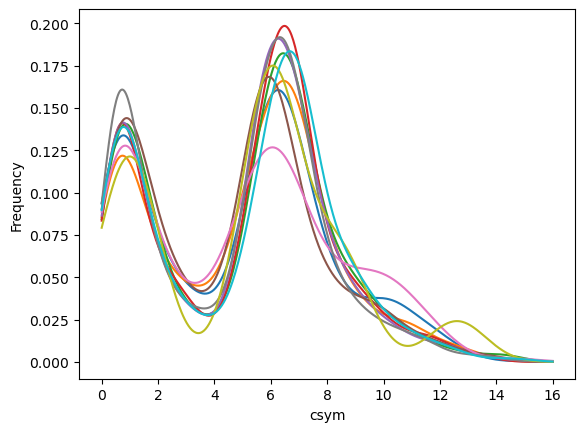

In [4]:
from scipy.stats import gaussian_kde


for i in range(len(my_ase)):
    my_idx = filter_csym_index(my_ase[i],.3)
    data = my_ase[i].arrays['c_csym'][my_idx]
    kde = gaussian_kde(data.flatten())
    x = np.linspace(0, 16, 500)
    plt.plot(x, kde(x))
    plt.xlabel("csym")
    plt.ylabel("Frequency")
    

We can use now use this new representation as input for any ML algorithm.

In [5]:
from sklearn.pipeline import make_pipeline, make_union
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error

X = []
for i in range(len(my_ase)):
    my_idx = filter_csym_index(my_ase[i],.3)
    data = my_ase[i].arrays['c_csym'][my_idx]
    kde = gaussian_kde(data.flatten())
    x = np.linspace(0, 16, 500)
    X.append(kde(x))
X = np.array(X)
y = np.load('../sample_energy.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.75, test_size=0.25)

my_custom_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
tpot = TPOTRegressor(generations=5, population_size=50,verbosity=2,scoring=my_custom_scorer)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

/home/cbo27/.conda/envs/mat_env/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -38.543652929223626

Generation 2 - Current best internal CV score: -31.48381763517562

Generation 3 - Current best internal CV score: -31.48381763517562

Generation 4 - Current best internal CV score: -31.48381763517562

Generation 5 - Current best internal CV score: -31.48381763517562

Best pipeline: ElasticNetCV(ZeroCount(Nystroem(input_matrix, gamma=0.2, kernel=polynomial, n_components=1)), l1_ratio=0.9500000000000001, tol=0.1)
-19.106557399770185
